## Initialisation
- Import libraries and functions
- Create SparkSession using config options to support reading from S3 bucket
- Set useful output formats and options

In [ ]:
from itertools import chain
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.mllib.stat import Statistics


jars = '/home/ubuntu/hadoop-2.7.3/share/hadoop/tools/lib/aws-java-sdk-1.7.4.jar:' \
       '/home/ubuntu/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-aws-2.7.3.jar'
    
spark = SparkSession.builder.master("local").appName("USHealth") \
                    .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') \
                    .config('spark.driver.extraClassPath', jars) \
                    .config('spark.hadoop.fs.s3a.access.key', 'xxxxxxxxxxxxxxxxxxxx') \
                    .config('spark.hadoop.fs.s3a.secret.key', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') \
                    .getOrCreate()

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# set pandas and numpy options to make print format nicer
pd.set_option('display.width',110); pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', 200); pd.set_option('display.max_rows', 500)

## Read two mapping files into dataframes
- Read files from Amazon S3 bucket into Spark dataframes
- Format columns as required to enable joins to dataset below

In [3]:
# read and process city FIPS to county FIPS mapping file
city_to_fips = spark.read.format("org.apache.spark.csv").option("header","true") \
                         .csv("s3a://cca.project.bucket1/uscitiesLatLongFIPS.csv")
#                          .csv("/home/ubuntu/project/data/uscitiesLatLongFIPS.csv")

city_to_fips = city_to_fips.withColumn("county_FIPS", f.lpad(city_to_fips['county_FIPS'],5,"0"))
city_to_fips = city_to_fips.drop("city","zip","id","source","population")
city_to_fips = city_to_fips.withColumn("city_ascii", f.regexp_replace('city_ascii', 'Saint', 'St.'))
city_to_fips = city_to_fips.withColumnRenamed("city_ascii","CityName") \
                           .withColumnRenamed("state_name","StateDesc") \
                           .withColumnRenamed("county_FIPS","FIPS")

print((city_to_fips.count(), len(city_to_fips.columns)))
city_to_fips.limit(5).toPandas()


# read and process commuting zone to county FIPS mappingfile
cz_to_fips = spark.read.format("org.apache.spark.csv").option("header","true").option("delimiter", "\t") \
                       .csv("s3a://cca.project.bucket1/1990LMAascii.csv")
#                        .csv("/home/ubuntu/project/data/1990LMAascii.csv")
    
cz_to_fips = cz_to_fips.filter(cz_to_fips.FIPS !="None")
cz_to_fips = cz_to_fips.withColumn("stateabbrv", cz_to_fips["County Name"].substr(-2,99))
cz_to_fips = cz_to_fips.withColumnRenamed("LMA/CZ","cz")
cz_to_fips = cz_to_fips.withColumn("cz", cz_to_fips["cz"].cast("Integer"))

print((cz_to_fips.count(), len(cz_to_fips.columns)))
cz_to_fips.limit(5).toPandas()

(38146, 7)


,CityName,state_id,StateDesc,county_name,FIPS,lat,lng
0,Dunseith,ND,North Dakota,Rolette,38079,48.8130569,-100.0609678
1,Mylo,ND,North Dakota,Rolette,38079,48.6352785,-99.6187555
2,Antler,ND,North Dakota,Bottineau,38009,48.9708532,-101.2823803
3,Bottineau,ND,North Dakota,Bottineau,38009,48.8272301,-100.4456984
4,Gardena,ND,North Dakota,Bottineau,38009,48.700837,-100.4976393


(3141, 6)


,cz,FIPS,County Name,Total Population,Labor Force,stateabbrv
0,100,47019,"Carter County, TN",51505,24411,TN
1,100,47059,"Greene County, TN",55853,28320,TN
2,100,47073,"Hawkins County, TN",44565,20894,TN
3,100,47163,"Sullivan County, TN",143596,69733,TN
4,100,47171,"Unicoi County, TN",16549,7587,TN


## Read Life Expectancy HDFS file into dataframe and process
- Read file from S3 bucket into Spark dataframe and drop unneeeded columns
- Join to cz_fips dataframe to get county FIPS code (this creates lots more rows for life expectancy by county)

In [ ]:
life = spark.read.format("org.apache.spark.csv").option("header","true").option("comment",",") \
                 .csv("s3a://cca.project.bucket1/health_ineq_all_online_tables.csv")
#                  .csv("/home/ubuntu/project/data/health_ineq_all_online_tables.csv")
print((life.count(), len(life.columns)))

life = life.drop("rownum","czname","pop2000","fips", "_c7","_c16","_c25","_c34","_c43","_c48")                 
life = life.join(cz_to_fips, ["cz"], "left")

print((life.count(), len(life.columns)))
# life.limit(2).toPandas()

## Read Health HDFS file into dataframe and process

- Read file from S3 bucket into Spark dataframe
- Set CityName to "Average" for United States so we have a National row
- Filter out unneededed rows
- Calculate health score for each health measure (row) by multiplying by weights
- Format fields as required

In [5]:
health_R = spark.read.format("org.apache.spark.csv").option("header","true") \
                     .csv("s3a://cca.project.bucket1/500_Cities.csv")
#                      .csv("/home/ubuntu/data/project/500_Cities.csv")
print((health_R.count(), len(health_R.columns)))
health_R.limit(5).toPandas()

health_R = health_R.withColumn("CityName", f.when(health_R["StateDesc"] == "United States", "Average") \
                                            .otherwise(health_R["CityName"]))

health_R = health_R.filter((health_R['Data_Value_Type']=='Crude prevalence') & 
                           (health_R['GeographicLevel'].isin(['City','US']) ))
print((health_R.count(), len(health_R.columns)))

health_R = health_R.select('StateDesc','CityName','Data_Value','PopulationCount','CityFIPS','Short_Question_Text')

weights = {'Health Insurance':        6,
           'Arthritis':               3,
           'Binge Drinking':          6,
           'High Blood Pressure':     7,
           'Taking BP Medication':    3,
           'Cancer (except skin)':   10,
           'Current Asthma':          4,
           'Coronary Heart Disease': 10,
           'Annual Checkup':         -3,
           'Cholesterol Screening':  -3,
           'Colorectal Cancer Screening': -2,
           'COPD'                       : 10,
           'Core preventive services for older men':   -3,
           'Core preventive services for older women': -3,
           'Current Smoking':         7,
           'Dental Visit':           -1,
           'Diabetes':                8,
           'High Cholesterol':        6,
           'Chronic Kidney Disease':  8,
           'Physical Inactivity':     3,
           'Mammography':            -2,
           'Mental Health':           6,
           'Obesity':                 7,
           'Pap Smear Test':         -2,
           'Sleep < 7 hours':         2,
           'Physical Health':         5,
           'Stroke':                  9,
           'Teeth Loss':              1,
          }

mapping_expr = f.create_map([f.lit(x) for x in chain(*weights.items())])

health_R = health_R.withColumn("Weight", mapping_expr.getItem(f.col("Short_Question_Text")))
health_R = health_R.withColumn("Score", health_R.Data_Value * health_R.Weight)
health_R = health_R.withColumn("Data_Value", health_R["Data_Value"].cast("Double"))

health_R.printSchema()
health_R.limit(5).toPandas()

(810103, 24)


,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2015,US,United States,None,US,BRFSS,Prevention,59,Current lack of health insurance among adults aged 18–64 Years,%,AgeAdjPrv,Age-adjusted prevalence,15.4,15.1,15.7,None,None,"308,745,538",None,PREVENT,ACCESS2,None,None,Health Insurance
1,2015,US,United States,None,US,BRFSS,Prevention,59,Current lack of health insurance among adults aged 18–64 Years,%,CrdPrv,Crude prevalence,14.8,14.5,15.0,None,None,"308,745,538",None,PREVENT,ACCESS2,None,None,Health Insurance
2,2015,US,United States,None,US,BRFSS,Health Outcomes,59,Arthritis among adults aged >=18 Years,%,AgeAdjPrv,Age-adjusted prevalence,22.5,22.3,22.7,None,None,"308,745,538",None,HLTHOUT,ARTHRITIS,None,None,Arthritis
3,2015,US,United States,None,US,BRFSS,Health Outcomes,59,Arthritis among adults aged >=18 Years,%,CrdPrv,Crude prevalence,24.7,24.5,24.9,None,None,"308,745,538",None,HLTHOUT,ARTHRITIS,None,None,Arthritis
4,2015,US,United States,None,US,BRFSS,Unhealthy Behaviors,59,Binge drinking among adults aged >=18 Years,%,AgeAdjPrv,Age-adjusted prevalence,17.2,16.9,17.4,None,None,"308,745,538",None,UNHBEH,BINGE,None,None,Binge Drinking


(14028, 24)
root
 |-- StateDesc: string (nullable = true)
 |-- CityName: string (nullable = true)
 |-- Data_Value: double (nullable = true)
 |-- PopulationCount: string (nullable = true)
 |-- CityFIPS: string (nullable = true)
 |-- Short_Question_Text: string (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Score: double (nullable = true)



,StateDesc,CityName,Data_Value,PopulationCount,CityFIPS,Short_Question_Text,Weight,Score
0,United States,Average,14.8,"308,745,538",None,Health Insurance,6,88.8
1,United States,Average,24.7,"308,745,538",None,Arthritis,3,74.1
2,United States,Average,16.3,"308,745,538",None,Binge Drinking,6,97.8
3,United States,Average,31.9,"308,745,538",None,High Blood Pressure,7,223.3
4,United States,Average,77.2,"308,745,538",None,Taking BP Medication,3,231.6


## Build final total dataframe 
- Build health1 dataframe with health data values all pivoted into 1 row for each city
- Build health2 dataframe of distinct state, city, population and FIPS
- Join the above two dataframes on state and city to get final health dataframe
- Join this to the city_to_fips dataframe to add the county FIPS code 
- Finally create the total dataframe as a join of health and life dataframes

In [6]:
health1 = health_R.groupBy("StateDesc", "CityName").pivot("Short_Question_Text").sum("Data_Value")
health2 = health_R.groupBy('StateDesc','CityName','PopulationCount','CityFIPS').sum("Score") \
                  .withColumnRenamed("sum(Score)","Raw Score")

# normalise health score to range 0 to 100
min_score, max_score = health2.agg(f.min("Raw Score"), f.max("Raw Score")).take(1)[0]
health2 = health2.withColumn("Score", 
                  (100*(1-(health2["Raw Score"] - min_score) / (max_score-min_score))).cast("Integer") )

# join back to previous dataframe to pickup info list in the groupby
health = health1.join(health2, ["StateDesc", "CityName"], "left")

# join to the city_to_fips dataframe to get county FIPS code
health = health.join(city_to_fips, ["StateDesc","CityName"], "left")
# print((health.count(), len(health.columns)))
# health.limit(5).toPandas()

# build the total dataframe from health and life
total = health.join(life, ['FIPS'], 'left')
print((total.count(), len(total.columns)))
total.limit(5).toPandas()


print("\nCheck for any nulls - should be empty or just United States Average")
total.filter(total.count_q4_M.isNull()).toPandas()

(501, 86)


,FIPS,StateDesc,CityName,Annual Checkup,Arthritis,Binge Drinking,COPD,Cancer (except skin),Cholesterol Screening,Chronic Kidney Disease,Colorectal Cancer Screening,Core preventive services for older men,Core preventive services for older women,Coronary Heart Disease,Current Asthma,Current Smoking,Dental Visit,Diabetes,Health Insurance,High Blood Pressure,High Cholesterol,Mammography,Mental Health,Obesity,Pap Smear Test,Physical Health,Physical Inactivity,Sleep < 7 hours,Stroke,Taking BP Medication,Teeth Loss,PopulationCount,CityFIPS,Raw Score,Score,state_id,county_name,lat,lng,cz,statename,stateabbrv,le_raceadj_q1_F,le_agg_q1_F,le_raceadj_q2_F,le_agg_q2_F,le_raceadj_q3_F,le_agg_q3_F,le_raceadj_q4_F,le_agg_q4_F,le_raceadj_q1_M,le_agg_q1_M,le_raceadj_q2_M,le_agg_q2_M,le_raceadj_q3_M,le_agg_q3_M,le_raceadj_q4_M,le_agg_q4_M,sd_le_raceadj_q1_F,sd_le_agg_q1_F,sd_le_raceadj_q2_F,sd_le_agg_q2_F,sd_le_raceadj_q3_F,sd_le_agg_q3_F,sd_le_raceadj_q4_F,sd_le_agg_q4_F,sd_le_raceadj_q1_M,sd_le_agg_q1_M,sd_le_raceadj_q2_M,sd_le_agg_q2_M,sd_le_raceadj_q3_M,sd_le_agg_q3_M,sd_le_raceadj_q4_M,sd_le_agg_q4_M,count_q1_F,count_q2_F,count_q3_F,count_q4_F,count_q1_M,count_q2_M,count_q3_M,count_q4_M,County Name,Total Population,Labor Force,stateabbrv
0,36067,New York,Syracuse,71.5,24.8,16.2,8.2,5.3,68.4,2.8,58.7,28.2,24.6,6.3,12.2,24.5,54.9,10.4,15.7,28.8,33.5,72.0,16.6,29.7,76.0,15.4,32.4,39.1,3.7,73.3,21.2,"145,170",3673000,980.2,45,NY,Onondaga,43.0481221,-76.1474244,17700,New York,NY,81.65,81.21,84.62,84.26,86.39,86.05,88.26,88.05,76.83,76.36,80.53,80.11,83.57,83.18,86.07,85.8,0.22,0.22,0.23,0.23,0.23,0.24,0.29,0.3,0.19,0.18,0.21,0.2,0.22,0.22,0.28,0.28,"592,845","718,776","761,885","586,816","568,899","696,898","735,859","553,018","Onondaga County, NY",468973,241248,NY
1,51550,Virginia,Chesapeake,76.1,22.7,15.8,5.7,6.0,79.3,2.4,68.6,39.2,34.0,5.0,8.6,17.7,72.0,10.3,12.2,32.9,35.5,79.8,11.1,32.9,85.6,10.5,26.1,38.1,2.8,77.9,13.3,"222,209",5116000,656.6,66,VA,Chesapeake (city),36.8190369,-76.2749399,2000,Virginia,VA,81.75,80.74,83.67,83.12,85.44,85.14,87.11,86.94,75.56,74.35,79.19,78.5,82.31,81.87,85.31,85.03,0.24,0.21,0.24,0.23,0.25,0.25,0.26,0.26,0.21,0.17,0.22,0.21,0.21,0.21,0.25,0.25,"692,607","702,236","744,420","681,509","537,349","653,732","740,058","647,532","Chesapeake city, VA",151976,79979,VA
2,06083,California,Santa Maria,59.6,18.4,17.1,5.9,4.8,64.0,2.8,51.8,24.5,23.7,5.6,9.2,16.7,51.6,11.0,26.9,27.9,34.5,72.8,15.3,29.3,76.2,15.7,26.9,35.9,3.0,65.1,17.2,"99,553",0669196,947.4,47,CA,Santa Barbara,34.9530337,-120.4357191,38200,California,CA,83.96,84.73,84.71,85.27,86.5,86.78,88.74,88.77,79.4,80.11,81.77,82.31,83.99,84.19,86.3,86.27,0.29,0.28,0.36,0.35,0.34,0.34,0.29,0.29,0.26,0.26,0.31,0.31,0.31,0.32,0.26,0.26,"334,211","354,307","371,912","447,213","345,190","338,207","354,664","414,476","Santa Barbara County, CA",369608,194422,CA
3,06083,California,Santa Barbara,63.6,18.8,18.9,4.6,6.3,75.0,2.5,64.2,30.2,30.2,4.9,8.2,11.7,68.8,8.3,12.3,26.6,32.7,78.3,11.0,23.8,82.7,10.8,18.2,30.8,2.4,69.0,8.9,"88,410",0669070,509.2,75,CA,Santa Barbara,34.4208305,-119.6981901,38200,California,CA,83.96,84.73,84.71,85.27,86.5,86.78,88.74,88.77,79.4,80.11,81.77,82.31,83.99,84.19,86.3,86.27,0.29,0.28,0.36,0.35,0.34,0.34,0.29,0.29,0.26,0.26,0.31,0.31,0.31,0.32,0.26,0.26,"334,211","354,307","371,912","447,213","345,190","338,207","354,664","414,476","Santa Barbara County, CA",369608,194422,CA
4,06111,California,Simi Valley,65.7,19.2,18.1,4.5,6.0,78.6,2.1,65.8,28.1,29.4,4.3,8.2,12.1,71.1,7.7,9.0,25.8,31.9,78.0,11.0,21.5,84.2,10.3,17.4,29.2,2.2,69.9,8.6,"124,237",0672016,420.3,80,CA,Ventura,34.2694474,-118.781482,38300,California,CA,83.2,84.94,83.28,84.93,84.6,85.97,86.58,87.61,79,80.51,80.14,81.42,81.82,82.8,84.94,85.53,0.22,0.06,0.23,0.08,0.21,0.08,0.19,0.07,0.16,0.05,0.16,0.07,0.15,0.07,0.14,0.06,"10,536,712","8,789,326","8,153,923","9,714,982","10,588,031","8,488,283","7,734,991","9,600,396","Ventura County, CA",669016,359124,CA



Check for any nulls - should be empty or just United States Average


,FIPS,StateDesc,CityName,Annual Checkup,Arthritis,Binge Drinking,COPD,Cancer (except skin),Cholesterol Screening,Chronic Kidney Disease,Colorectal Cancer Screening,Core preventive services for older men,Core preventive services for older women,Coronary Heart Disease,Current Asthma,Current Smoking,Dental Visit,Diabetes,Health Insurance,High Blood Pressure,High Cholesterol,Mammography,Mental Health,Obesity,Pap Smear Test,Physical Health,Physical Inactivity,Sleep < 7 hours,Stroke,Taking BP Medication,Teeth Loss,PopulationCount,CityFIPS,Raw Score,Score,state_id,county_name,lat,lng,cz,statename,stateabbrv,le_raceadj_q1_F,le_agg_q1_F,le_raceadj_q2_F,le_agg_q2_F,le_raceadj_q3_F,le_agg_q3_F,le_raceadj_q4_F,le_agg_q4_F,le_raceadj_q1_M,le_agg_q1_M,le_raceadj_q2_M,le_agg_q2_M,le_raceadj_q3_M,le_agg_q3_M,le_raceadj_q4_M,le_agg_q4_M,sd_le_raceadj_q1_F,sd_le_agg_q1_F,sd_le_raceadj_q2_F,sd_le_agg_q2_F,sd_le_raceadj_q3_F,sd_le_agg_q3_F,sd_le_raceadj_q4_F,sd_le_agg_q4_F,sd_le_raceadj_q1_M,sd_le_agg_q1_M,sd_le_raceadj_q2_M,sd_le_agg_q2_M,sd_le_raceadj_q3_M,sd_le_agg_q3_M,sd_le_raceadj_q4_M,sd_le_agg_q4_M,count_q1_F,count_q2_F,count_q3_F,count_q4_F,count_q1_M,count_q2_M,count_q3_M,count_q4_M,County Name,Total Population,Labor Force,stateabbrv
0,None,United States,Average,70.0,24.7,16.3,6.3,6.6,77.0,2.7,63.7,32.3,30.7,6.3,8.8,16.8,64.4,10.4,14.8,31.9,37.1,75.8,11.4,28.8,81.8,12.0,25.9,34.8,3.0,77.2,14.9,"308,745,538",None,770.0,59,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## Get Best and Worst cities
Simple top and bottom 10 cities


In [15]:
top_bottom = total.select("CityName","StateDesc", "Score")

print("Top 10 Best Cities for Health")
top_bottom.sort("Score").limit(10).toPandas()

print("Top 10 Worst Cities for Health")
top_bottom.sort(f.desc("Score")).limit(10).toPandas()

print("Interesting Cities")
interesting_cities = ['Champaign', 'Chicago', 'New York', 'Los Angeles', 'San Francisco']
total.filter(total.CityName.isin(interesting_cities)).select("CityName","StateDesc","Score").toPandas()

Top 10 Best Cities for Health


,CityName,StateDesc,Score
0,Gary,Indiana,0
1,Detroit,Michigan,9
2,Youngstown,Ohio,11
3,Flint,Michigan,15
4,Reading,Pennsylvania,17
5,Cleveland,Ohio,17
6,Camden,New Jersey,18
7,Macon,Georgia,18
8,Dayton,Ohio,22
9,Birmingham,Alabama,25


Top 10 Worst Cities for Health


,CityName,StateDesc,Score
0,San Ramon,California,100
1,Mountain View,California,96
2,Irvine,California,96
3,Sunnyvale,California,95
4,Cambridge,Massachusetts,94
5,Pleasanton,California,94
6,Fremont,California,93
7,Santa Clara,California,93
8,Redondo Beach,California,93
9,Boulder,Colorado,93


Interesting Cities


,CityName,StateDesc,Score
0,Chicago,Illinois,50
1,San Francisco,California,80
2,New York,New York,60
3,Los Angeles,California,62
4,Champaign,Illinois,70


## Display Health Measure Correlations

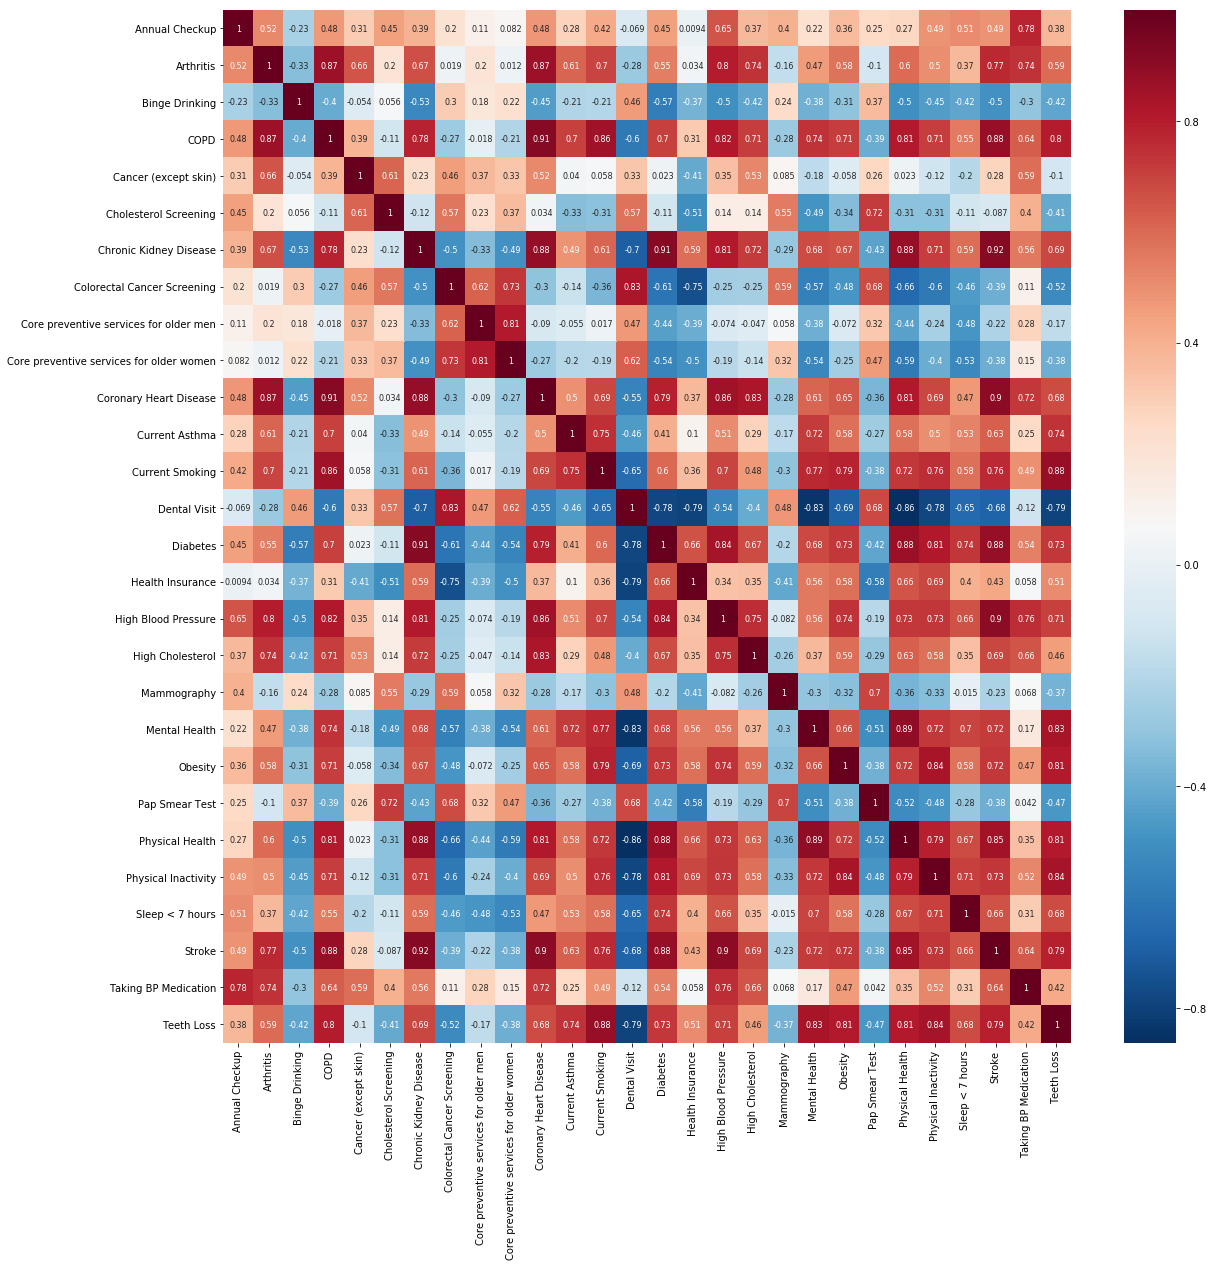

In [14]:
corr_matrix = Statistics.corr(health1.drop("StateDesc", "CityName").rdd.map(tuple), method="pearson")

# transform to dataframe so can easily and column and row names
dfcorr = pd.DataFrame(corr_matrix)
dfcorr.columns = health1.schema.names[2:]
dfcorr.index   = health1.schema.names[2:]

_ = plt.figure(figsize=(19,19))
_ = sns.heatmap(dfcorr, annot=True, cmap='RdBu_r', annot_kws={"size": 8})